In [ ]:
pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import MinMaxScaler
# from handyspark import *
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
import pandas as pd
ff=pd.read_csv("/content/F-F_Research_Data_Factors_daily 2.CSV")
ff.head(5)

In [ ]:
spark = SparkSession.builder.appName('FamaFrench').getOrCreate()

In [ ]:
csv_path = "/content/allequities.csv"

In [ ]:
import timeit

In [ ]:
# print(%timeit)
sdf_real_estate=spark.read.csv(csv_path,header=True, inferSchema=True)
sdf_real_estate.groupBy('INSTRUMENT_IDENTIFIER').count().show()
# print(%timeit)

+---------------------+-----+
|INSTRUMENT_IDENTIFIER|count|
+---------------------+-----+
|            Apple Inc| 4956|
|  JPMorgan Chase & Co|  495|
|         Facebook Inc| 4956|
|              Addidas| 4956|
|          Netflix Inc| 4956|
+---------------------+-----+



In [ ]:
def getPandasDataframe():
  pd_equity=pd.read_csv(csv_path,header=True, inferSchema=True)
  pd_equity.groupBy('INSTRUMENT_IDENTIFIER').count()

In [ ]:
pd_equity=pd.read_csv(csv_path,header=True, inferSchema=True)
pd_equity.groupBy('INSTRUMENT_IDENTIFIER').count()

TypeError: ignored

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


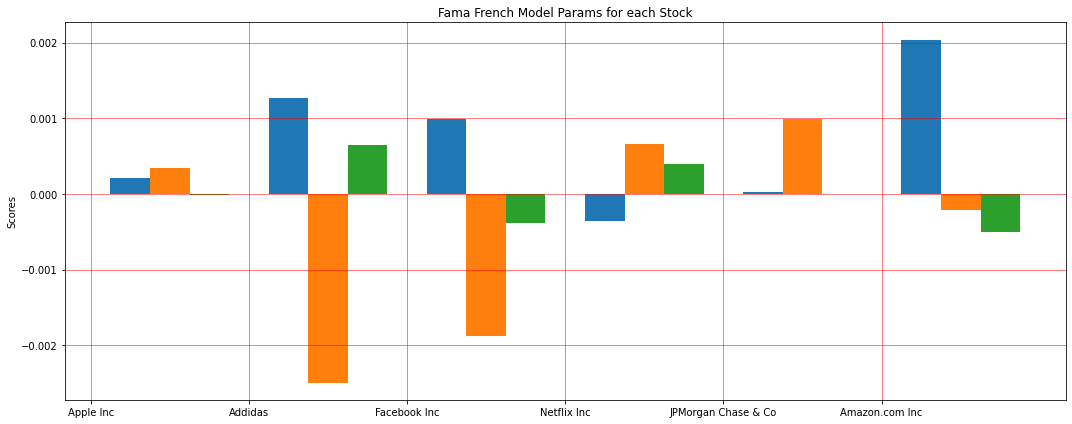

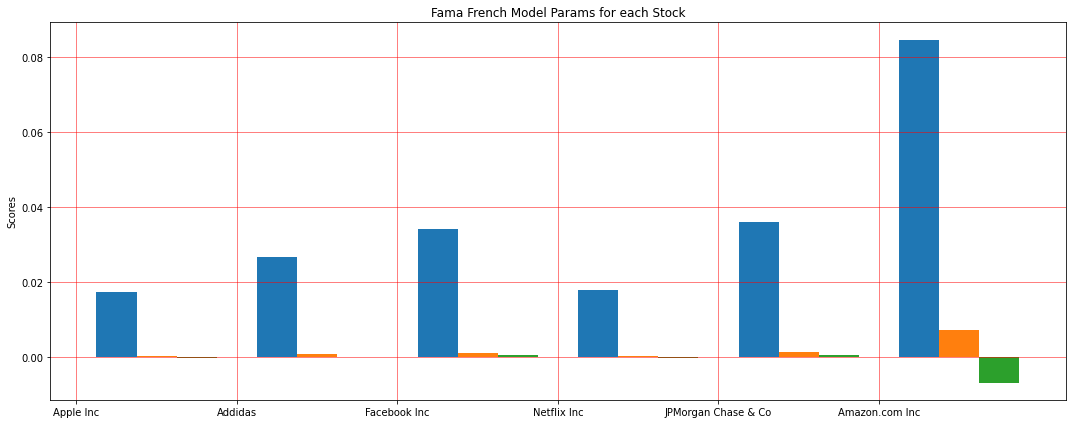

,StockName,SMB,HML,Rf,R2,Adjusted R2,Multiple R,F-statistic
0,Apple Inc,0.000210,0.000338,-0.000011,0.000306,-0.000300,0.017493,0.678705
1,Addidas,0.001272,-0.002495,0.000644,0.000719,0.000113,0.026813,0.312940
2,Facebook Inc,0.000991,-0.001883,-0.000383,0.001171,0.000566,0.034226,0.121556
3,Netflix Inc,-0.000364,0.000656,0.000390,0.000316,-0.000290,0.017775,0.667426
4,JPMorgan Chase & Co,0.000031,0.000990,-0.000001,0.001298,0.000692,0.036022,0.092492
5,Amazon.com Inc,0.002041,-0.000219,-0.000499,0.007173,-0.006811,0.084692,0.673779


In [ ]:
df_ff=pd.read_csv("/content/F-F_Research_Data_Factors_daily 2.CSV")
df_eq=pd.read_csv("/content/allequities.csv")
# df_ff['Date']
df_ff['PRICE_DATE_YYYYMMDD']=pd.to_datetime(df_ff['Date'], format='%Y%m%d')
df_eq['PRICE_DATE_YYYYMMDD']=pd.to_datetime(df_ff['PRICE_DATE_YYYYMMDD'], format='%Y%m%d')
columns=['StockName','SMB','HML','Rf','R2','Adjusted R2','Multiple R','F-statistic']
df_ff_summary=pd.DataFrame(columns=columns)     
for stock in df_eq['INSTRUMENT_IDENTIFIER'].unique()[0:10]:
  df_stock=df_eq[df_eq['INSTRUMENT_IDENTIFIER']==stock][['Close','PRICE_DATE_YYYYMMDD']]
  df_stock=pd.merge(df_stock,df_ff,on="PRICE_DATE_YYYYMMDD")
  df_stock['Daily Returns']=df_stock['Close'].pct_change()
  df_stock['Excess Daily Returns']=df_stock['Daily Returns']#-df_stock['RF']
  df_stock.dropna(inplace=True)
  if df_stock['Excess Daily Returns'].size>0:
    y = df_stock['Excess Daily Returns']
    X = df_stock[['Mkt-RF','SMB','HML']]
    X_sm = sm.add_constant(X)
    model = sm.OLS(y,X_sm)
    results = model.fit()    
    dict = {'StockName':stock,"SMB":results.params['SMB'],"HML":results.params['HML'],"Rf":results.params['Mkt-RF'],"R2":results.rsquared,'F-statistic':results.f_pvalue,"Adjusted R2":results.rsquared_adj,"Multiple R":np.sqrt(results.rsquared)}
    df_ff_summary=df_ff_summary.append(dict,ignore_index=True)    
plot_groupedbar(df_ff_summary.StockName,[df_ff_summary['SMB'],df_ff_summary['HML'],df_ff_summary['Rf']])   
plot_groupedbar(df_ff_summary.StockName,[df_ff_summary['Multiple R'],df_ff_summary['R2'],df_ff_summary['Adjusted R2']]) 
df_ff_summary

In [ ]:
def plot_groupedbar(labels,columns):
  fig, ax = plt.subplots(figsize=(15,6))
  plt.grid=True
  x = np.arange(len(labels))  # the label locations
  width = 1.5/(labels.size)
  i=1
  for col in columns:
      ax.bar(x + width*i, col, width, label=col)    
      i=i+1
  

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Scores')
  ax.set_title('Fama French Model Params for each Stock')
  ax.set_xticks(x)
  ax.grid(linestyle='-', linewidth='0.5', color='red')
  ax.set_xticklabels(labels)
  # ax.legend()

  fig.tight_layout()

  plt.show()
